<a href="https://colab.research.google.com/github/ykitaguchi77/statistics_for_articles/blob/main/Blepharospasm_sensory_trick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Blepharospasm_sensory_trick**

In [2]:
# prompt: gdriveをマウント

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Sex_label         Female  Male  Female (%)  Male (%)
Condition                                           
Blepharospasm         23     9        71.9      28.1
Hemifacial spasm      11     6        64.7      35.3
Age (Mann–Whitney U): U = 422.0, p = 0.0017
Sex (Chi‑square): χ² = 0.04, p = 0.8472


/tmp/ipython-input-12-1973009975.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=conditions_order, showfliers=True)


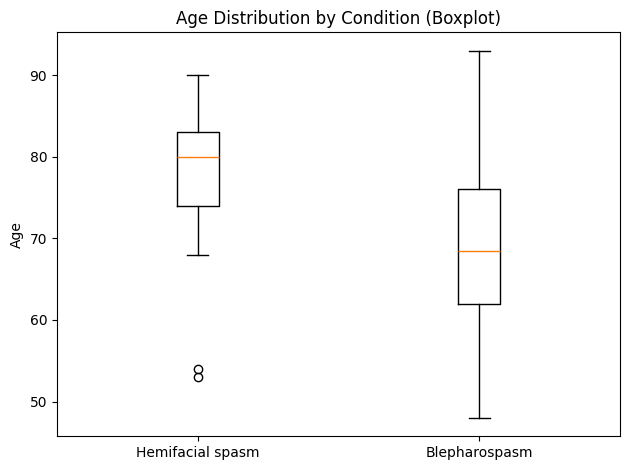

In [12]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "/content/drive/MyDrive/発表/2025神経眼科学会/知覚トリックの頻度調査.xlsx"
df = pd.read_excel(file_path, sheet_name='Data')

# Filter Type 0 & 1 and ensure required columns
df_filtered = df[['Type', 'Age', 'Sex']].dropna(subset=['Type', 'Age', 'Sex'])
df_filtered = df_filtered[df_filtered['Type'].isin([0, 1])]

# Map to condition and sex labels
condition_map = {0: 'Hemifacial spasm', 1: 'Blepharospasm'}
sex_map = {0: 'Male', 1: 'Female'}
df_filtered['Condition'] = df_filtered['Type'].map(condition_map)
df_filtered['Sex_label'] = df_filtered['Sex'].map(sex_map)

# ------------------------------
# Sex distribution table
# ------------------------------
sex_counts = pd.crosstab(df_filtered['Condition'], df_filtered['Sex_label'])
sex_pct = (sex_counts.div(sex_counts.sum(axis=1), axis=0) * 100).round(1)
sex_table = pd.concat([sex_counts, sex_pct.add_suffix(' (%)')], axis=1)

print(sex_table)

# ------------------------------
# Statistical tests
# ------------------------------
# Age: Mann-Whitney U
ages_hfs = df_filtered[df_filtered['Condition'] == 'Hemifacial spasm']['Age']
ages_bep = df_filtered[df_filtered['Condition'] == 'Blepharospasm']['Age']
u_stat, p_age = stats.mannwhitneyu(ages_hfs, ages_bep, alternative='two-sided')

# Sex: Chi-square test
chi2_stat, chi2_p, _, _ = stats.chi2_contingency(sex_counts)

print(f"Age (Mann–Whitney U): U = {u_stat:.1f}, p = {p_age:.4f}")
print(f"Sex (Chi‑square): χ² = {chi2_stat:.2f}, p = {chi2_p:.4f}")

# Boxplot
plt.figure()
conditions_order = ['Hemifacial spasm', 'Blepharospasm']
box_data = [df_filtered[df_filtered['Condition'] == c]['Age'] for c in conditions_order]
plt.boxplot(box_data, labels=conditions_order, showfliers=True)
plt.ylabel('Age')
plt.title('Age Distribution by Condition (Boxplot)')
plt.tight_layout()
plt.show()


In [13]:
# Clean column names (strip leading/trailing spaces)
df.columns = df.columns.str.strip()

# --- Filter to Type 1 (Blepharospasm) ---
bleph = df[df['Type'] == 1].copy()
n_total = len(bleph)

# --- Age summary ---
age_stats = bleph['Age'].describe()
age_iqr = age_stats['75%'] - age_stats['25%']
age_summary_df = pd.DataFrame({
    'Count': [int(age_stats['count'])],
    'Mean': [age_stats['mean']],
    'Median': [age_stats['50%']],
    'Std': [age_stats['std']],
    'IQR': [age_iqr]
})
print(age_summary_df)

# --- Sex distribution ---
sex_map = {0: 'Male', 1: 'Female'}
bleph['Sex_label'] = bleph['Sex'].map(sex_map)
sex_counts = bleph['Sex_label'].value_counts(dropna=False)
sex_pct = (sex_counts / n_total * 100).round(1)
sex_df = pd.DataFrame({'Count': sex_counts, 'Percent': sex_pct})
print(sex_df)

# --- Numeric variables summary ---
num_vars = ['Duration', 'Interval', 'Botox_unit']
summary_rows = []
for var in num_vars:
    s = bleph[var].describe()
    summary_rows.append({
        'Variable': var,
        'Count': int(s['count']),
        'Mean': s['mean'],
        'Median': s['50%'],
        'Std': s['std'],
        'IQR': s['75%'] - s['25%']
    })
num_summary_df = pd.DataFrame(summary_rows)
print(num_summary_df)

# --- Categorical variables summary ---
cat_vars = ['Botox_abovebrow', 'Botox_glabellar']
cat_summary_rows = []
for var in cat_vars:
    counts = bleph[var].value_counts(dropna=False)
    pct = (counts / n_total * 100).round(1)
    for category, count in counts.items():
        cat_summary_rows.append({
            'Variable': var,
            'Category': category,
            'Count': count,
            'Percent': pct[category]
        })
cat_summary_df = pd.DataFrame(cat_summary_rows)
print(cat_summary_df)

# --- Sensory trick presence ---
bleph['Sensory_trick_present'] = (
    (bleph['SensoryTrick_temple'] == 1) |
    (bleph['SensoryTrick_subbrow'] == 1)
).astype(float)

sens_counts = bleph['Sensory_trick_present'].value_counts(dropna=False)
sens_pct = (sens_counts / n_total * 100).round(1)
sense_df = pd.DataFrame({'Count': sens_counts, 'Percent': sens_pct})
print(sense_df)

# --- Subset Type 1 (Blepharospasm) ---
bleph = df[df['Type'] == 1].copy()
n_total = len(bleph)

# --- Surgery history flag from "History" column ---
def has_surgery(val):
    if pd.isna(val):
        return 'No'
    # numeric zero (int/float) or string '0'
    if isinstance(val, (int, float)) and val == 0:
        return 'No'
    if isinstance(val, str) and re.fullmatch(r'\s*0\s*', val):
        return 'No'
    return 'Yes'

bleph['Surgery_history'] = bleph['History'].apply(has_surgery)

# --- Surgery history distribution ---
hist_counts = bleph['Surgery_history'].value_counts(dropna=False)
hist_pct = (hist_counts / n_total * 100).round(1)
hist_df = pd.DataFrame({'Count': hist_counts, 'Percent': hist_pct})
print(hist_df)

# --- Numeric summaries by surgery history ---
num_vars = ['Duration', 'Interval']
summary_rows = []
for var in num_vars:
    for grp, grp_df in bleph.groupby('Surgery_history'):
        s = grp_df[var].describe()
        summary_rows.append({
            'Variable': var,
            'Surgery_history': grp,
            'Count': int(s['count']),
            'Mean': s['mean'],
            'Median': s['50%'],
            'Std': s['std'],
            'IQR': s['75%'] - s['25%']
        })
summary_df = pd.DataFrame(summary_rows)
print(summary_df)


   Count      Mean  Median        Std   IQR
0     32  68.03125    68.5  10.923441  14.0
           Count  Percent
Sex_label                
Female        23     71.9
Male           9     28.1
     Variable  Count        Mean  Median        Std      IQR
0    Duration     32  107.500000   110.0  58.151637  114.000
1    Interval     32    3.375000     3.0   1.047270    0.625
2  Botox_unit     32   40.398438    40.0   8.262786   15.000
          Variable  Category  Count  Percent
0  Botox_abovebrow       1.0     22     68.8
1  Botox_abovebrow       0.0     10     31.2
2  Botox_glabellar       1.0     17     53.1
3  Botox_glabellar       0.0     15     46.9
                       Count  Percent
Sensory_trick_present                
1.0                       21     65.6
0.0                       11     34.4
                 Count  Percent
Surgery_history                
No                  20     62.5
Yes                 12     37.5
   Variable Surgery_history  Count        Mean  Median     

In [14]:
# Subset to Type 1 (Blepharospasm)
bleph = df[df['Type'] == 1].copy()

# Parse Botox_dissatisfaction
def extract_duration(val):
    if pd.isna(val):
        return None
    # Regex to capture number followed by M/m
    match = re.search(r'(\d+(?:\.\d+)?)\s*[Mm]', str(val))
    if match:
        return float(match.group(1))
    return None

bleph['Effect_duration_M'] = bleph['Botox_dissatisfaction'].apply(extract_duration)

# Separate complaints (non-duration text)
def complaint_or_blank(val):
    if pd.isna(val):
        return None
    if extract_duration(val) is not None:
        return None
    # Strip and return text
    return str(val).strip()

bleph['Complaint_text'] = bleph['Botox_dissatisfaction'].apply(complaint_or_blank)

# --- Summary of effect duration ---
duration_series = bleph['Effect_duration_M'].dropna()
duration_stats = duration_series.describe()
duration_stats_df = pd.DataFrame(duration_stats).transpose()
duration_stats_df['IQR'] = duration_stats_df['75%'] - duration_stats_df['25%']
print(duration_stats_df)

# --- Distribution of complaints ---
complaints = bleph['Complaint_text'].dropna()
complaint_counts = complaints.value_counts()
complaint_df = complaint_counts.reset_index()
complaint_df.columns = ['Complaint', 'Count']
print(complaint_df)


                   count  mean  std  min  25%  50%  75%  max  IQR
Effect_duration_M    1.0   3.0  NaN  3.0  3.0  3.0  3.0  3.0  0.0
              Complaint  Count
0                     0     10
1                  ちょうど      3
2                   2ヶ月      2
3                 1.5ヶ月      1
4              2.5ヶ月、流涙      1
5           3ヶ月直前に効果切れる      1
6         眼は調子良い、口が調子悪い      1
7                   2週間      1
8              3ヶ月は持たない      1
9             効果ないと訴えあり      1
10    効果に不満、食事時につむってしまう      1
11            あまり効いていない      1
12    効果に不満。眉毛が落ちて開きにくい      1
13               2ヶ月ぐらい      1
14                 2ヶ月強      1
15    2ヶ月ぐらい。最近効果落ちてきた。      1
16             効果に不満、流涙      1
17  2ヶ月ぐらいでまぶしくて開けにくくなる      1
18                   なし      1
